<a href="https://colab.research.google.com/github/Braafisch/ASD-Assignments/blob/main/asd_assignment6/asd_assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Vorlesung ASD, HS Esslingen, Thao Dang

# Kalman-Filter 

In dieser Übung werden Sie - in enger Anlehnung an die Vorlesungsfolien - ein Kalman-Filter zum Tracking eines vorausfahrenden Fahrzeugs anhand von Kamera- und Radar-Daten exemplarisch untersuchen.

![tracking](https://drive.google.com/uc?id=1J26JqA7fW3IQ6sWxMH5h9bRga9yhlLO9)

Für ein Adaptive-Cruise-Control(ACC)-System sollen Sie die - jeweils relative - Entfernung $s$, Geschwindigkeit $v$ und Beschleunigung $a$ eines vorausfahrenden Objekts bestimmen. Sie können dazu vereinfachend annehmen, dass das Egofahrzeug selbst mit konstanter Geschwindigkeit fährt und ein Zustandsmodell mit konstantem Ruck entsprechen dem Zustandsmodell in der Vorlesung verwendet werden kann.

Im Unterschied zum Beispiel in der Vorlesung liegen hier aber drei Messungen vor:
1. der aus der Kamera gemessene Relativabstand $s_{camera}$ (z.B. über eine Ebenenannahme ermittelt)
2. der aus dem Radar gemessene Relativabstand $s_{radar}$ sowie
3. die mittels Radar gemessene Relativgeschwindigkeit $v_{radar}$. 

Es ergibt sich also in jedem diskreten Zeitschritt $k$ ein Beobachtungsvektor $\mathbf{y}(k) = (s_{camera}(k), s_{radar}(k), v_{radar}(k))^T$. 

## Vorbereitungen

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Laden der Messungen inkl. zugeordneten Zeitstempel sowie der wahren Positions- und Bewegungsdaten des Vorausfahrers. Die Form der geladenen Daten ist unten im Code angegeben. 

In [1]:
# Upload data
# KF_tracking_data.npz

import requests
import io
import shutil

url = 'https://raw.githubusercontent.com/Braafisch/ASD-Assignments/main/asd_assignment6/KF_tracking_data.npz'
response = requests.get(url, allow_redirects = True, stream = True).raw

with open('KF_tracking_data.npz', 'wb') as fin:
    shutil.copyfileobj(response, fin)

In [3]:
npzfile = np.load('KF_tracking_data.npz')
t = npzfile['t'] # timestamps: [t0, t1, ...], units: s
y = npzfile['y'] # observations: [[s_camera0, s_radar0, v_radar0], [s_camera1, s_radar1, v_radar1], ...]
                 # units: m, m, m/s
states_true = npzfile['states_true'] # true states: [[s0, v0, a0], [s1, v1, a1], ...]
                                     # units: m, m/s, m/ss

### A1.1

Stellen Sie zunächst die gemessenen Daten grafisch mit Matplotlib dar. Berechnen Sie zudem durch einfache diskrete Ableitung des Geschwindigkeitssignals einen (stark verrauschten) Schätzwert für die Beschleunigung des Voraussfahrers. 

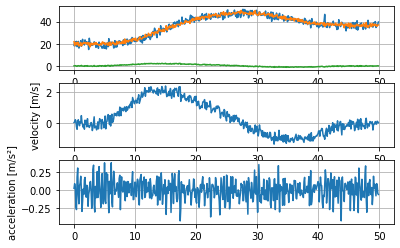

In [30]:
plt.subplot(3,1,1)
plt.plot(t, y)
plt.grid(True)

v = y[:,2]
a = np.gradient(v)

plt.subplot(3,1,2)
plt.plot(t, v)
plt.ylabel("velocity [m/s]")
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(t, a)
plt.ylabel("acceleration [m/s²]")
plt.grid(True)

### A1.2

Bestimmen Sie jetzt (in Anlehnung an die Vorlesungsfolien) die Zustandsraumbeschreibung für das Kalman-Filter, d.h. die Zutsandstransitionsmatrix ``Ad``, die Eingangsmatrix ``Bd``, die Designmatrix ``C`` und die Störmatrix für das Systemrauschen ``G``. 

In [37]:
Ts = t[1]-t[0] # sampling time
R = np.array([[2**2, 0, 0], [0, 1**2, 0], [0, 0, 0.2**2]]) # observation noise covariance
Q = 0.01**2 # system noise covariance

# HIER CODE EINFUEGEN
Ad = np.array([[1, Ts, 0.5*Ts**2], [0, 1, Ts], [0, 0, 1]])
Bd = np.array([[0], [0], [0]])
# Systemzustand x = [s,v,a]
# Beobachtungsvektor y = [s_camera,s_radar, v_radar] C * x = y 
C = np.array([[1, 0, 0], [1, 0, 0], [0, 1, 0]])

G = np.array([[0.5 * Ts**2], [Ts], [1]])

### A1.3 

Führen Sie nun - analog zu den Vorlesungsfolien! - die zyklische Berechnung des Kalman-Filters durch. 

Speichern Sie die in jedem Zeitschritt ermittelten Zustände in der Matrix ``states``, die folgende Form haben soll:
```
    [[s0, v0, a0], # s: Distanz, v: Geschwindigkeit, a: Beschleunigung 
     [s1, v1, a1], 
     ...]
```

Stellen Sie den Verlauf der geschätzten Zustandsgrößen dar und vergleichen Sie Ihr Ergebnis mit den wahren Werten ``states_true``.

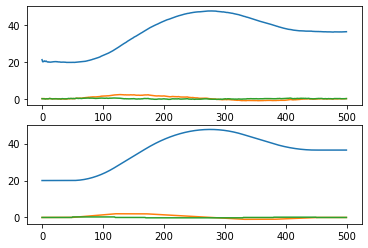

In [52]:
x0 = np.array([[y[0,1]], [y[0,2]], [0]])
P0 = np.array([[10**2, 0, 0], [0, 10**2, 0], [0, 0, 0.2**2]])

u = np.zeros((y.shape[0],)) # control input, not used here, so set to zero
states = np.zeros((y.shape[0], 3))

x = x0
P = P0

# HIER CODE EINFUEGEN
for k in range(y.shape[0]):

    CPCT = np.linalg.multi_dot([C, P, C.T]) # CPCT = C*P*C'
    assert CPCT.shape == (3, 3)
    K = np.linalg.multi_dot([P, C.T, np.linalg.pinv(CPCT + R)]) # K = P*C'*pinv(C*P*C'+R)
    assert K.shape == (3,3)
    
    I = np.eye(Bd.shape[0])
    x = x + np.dot(K, np.reshape(y[k,:], (3,1)) - np.dot(C, x)) # x = x + K*(y - C+x) 
    P = np.dot(I - np.dot(K, C), P) # P = (I - K*C)*P
    
    states[k,:] = x.T

    x = np.dot(Ad, x) + Bd * u[k] # x = Ad*x + Bd*u
    P = np.dot(Ad, np.dot(P, Ad.T)) + np.dot(G, np.dot(Q, G.T)) # P = P = Ad*P*Ad’ + G*Q*G’

plt.subplot(2,1,1)
plt.plot(states)

plt.subplot(2,1,2)
plt.plot(states_true)

### A2.1

Verwenden Sie nun einen offene Implementierung des Kalman-Filters und vergleichen Sie die Filterergebnisse. 

Hier wird die Bibliothek ``filterpy`` verwendet, die Sie in colab über den Befehl
```
!pip3 install filterpy
```
bzw. bei Ihrer lokalen Installation (mit Anaconda) über 
```
conda install -c conda-forge filterpy
```
oder (ohne Anaconda)
```
pip3 install filterpy
```
nachinstallieren können. Die entsprechenden Befehle zur Verwendung der Bibliothek sind nachfolgend schon befüllt. Veranschaulichen Sie sich den unten stehen Code und vergleichen Sie die Ergebnisse mit den Ergebnissen aus A1.

In [42]:
!pip3 install filterpy

     |████████████████████████████████| 184kB 6.9MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-cp37-none-any.whl size=110452 sha256=22ac27cd89604a7de68d2227020cdf47ec159887d11e65279f5398f7fdfc52af
  Stored in directory: /root/.cache/pip/wheels/c3/0c/dd/e92392c3f38a41371602d99fc77d6c1d42aadbf0c6afccdd02
Successfully built filterpy


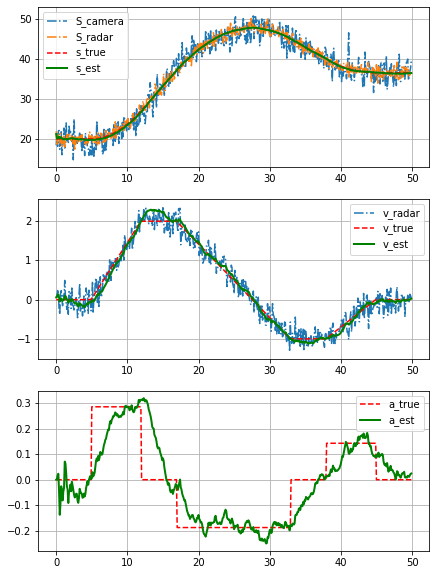

In [49]:
from filterpy.kalman import KalmanFilter # "conda install -c conda-forge filterpy" or "pip3 install filterpy"

f = KalmanFilter(dim_x=3, dim_z=3) # 3 state components, 3 observations

f.F = Ad # state transition matrix
f.H = C # design matrix

f.R = R # measurement noise covariance matrix
f.Q = np.dot(G, np.dot(Q, G.T)) # system noise covariance matrix

f.x = x0 # initial state vector
f.P = P0 # initial covariance

for k in range(y.shape[0]):
    f.predict()
    f.update(np.reshape(y[k,:], (3,1)))
    states[k,:] = f.x.T

    
plt.figure(figsize=(7,10))
plt.subplot(3,1,1)
plt.plot(t, y[:,0], '-.', label='S_camera')
plt.plot(t, y[:,1], '-.', label='S_radar')
plt.plot(t, states_true[:,0], 'r--', label='s_true')
plt.plot(t, states[:,0], 'g', label='s_est', lw=2)
plt.grid(True)
plt.legend()

plt.subplot(3,1,2)
plt.plot(t, y[:,2], '-.', label='v_radar')
plt.plot(t, states_true[:,1], 'r--', label='v_true')
plt.plot(t, states[:,1], 'g', label='v_est', lw=2)

plt.grid(True)
plt.legend()

plt.subplot(3,1,3)
plt.plot(t, states_true[:,2], 'r--', label='a_true')
plt.plot(t, states[:,2], 'g', label='a_est', lw=2)
plt.grid(True)
plt.legend();

### A2.2

Verändern Sie nun das Systemrauschen ``Q`` sowie das Messrauschen ``R``. Welchen Einfluss hat die Veränderung dieser Größen auf Ihr Ergebnis?

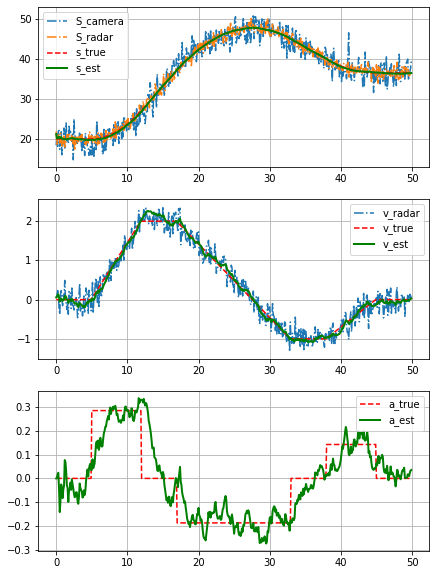

In [55]:
Q = 0.02**2
G = np.array([[0.25 * Ts**2], [Ts], [1]])

from filterpy.kalman import KalmanFilter # "conda install -c conda-forge filterpy" or "pip3 install filterpy"

f = KalmanFilter(dim_x=3, dim_z=3) # 3 state components, 3 observations

f.F = Ad # state transition matrix
f.H = C # design matrix

f.R = R # measurement noise covariance matrix
f.Q = np.dot(G, np.dot(Q, G.T)) # system noise covariance matrix 

f.x = x0 # initial state vector
f.P = P0 # initial covariance

for k in range(y.shape[0]):
    f.predict()
    f.update(np.reshape(y[k,:], (3,1)))
    states[k,:] = f.x.T

    
plt.figure(figsize=(7,10))
plt.subplot(3,1,1)
plt.plot(t, y[:,0], '-.', label='S_camera')
plt.plot(t, y[:,1], '-.', label='S_radar')
plt.plot(t, states_true[:,0], 'r--', label='s_true')
plt.plot(t, states[:,0], 'g', label='s_est', lw=2)
plt.grid(True)
plt.legend()

plt.subplot(3,1,2)
plt.plot(t, y[:,2], '-.', label='v_radar')
plt.plot(t, states_true[:,1], 'r--', label='v_true')
plt.plot(t, states[:,1], 'g', label='v_est', lw=2)

plt.grid(True)
plt.legend()

plt.subplot(3,1,3)
plt.plot(t, states_true[:,2], 'r--', label='a_true')
plt.plot(t, states[:,2], 'g', label='a_est', lw=2)
plt.grid(True)
plt.legend();